# Food Delivery Time Prediction

In [1]:
#pip install optuna

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import optuna
import pickle

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb



## 1. Data Loading and Initial Exploration


In [3]:
# Load the data
df = pd.read_csv('Food_Delivery_Times_updated.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nDescriptive Statistics:")
df.describe()


Dataset Shape: (10000, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              10000 non-null  int64  
 1   Distance_km             10000 non-null  float64
 2   Weather                 10000 non-null  object 
 3   Traffic_Level           10000 non-null  object 
 4   Time_of_Day             10000 non-null  object 
 5   Vehicle_Type            10000 non-null  object 
 6   Preparation_Time_min    10000 non-null  int64  
 7   Courier_Experience_yrs  10000 non-null  float64
 8   Delivery_Time_min       10000 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 703.3+ KB

Descriptive Statistics:


,Unnamed: 0,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4999.50000,10.007740,16.903300,4.523926,56.627600
std,2886.89568,5.718424,7.229701,2.876956,22.109351
min,0.00000,0.536036,4.000000,-0.167378,7.000000
25%,2499.75000,4.972030,11.000000,2.000000,41.000000
50%,4999.50000,9.918335,17.000000,4.523926,55.000000
75%,7499.25000,14.875634,23.000000,7.000000,70.000000
max,9999.00000,23.025841,35.000000,10.565020,163.000000


In [4]:
# dropping the unnamed O colum
df.drop(columns=['Unnamed: 0'], inplace=True)


## 2. Exploratory Data Analysis (EDA)


In [5]:
# Check missing values
print("Missing Values:")
print(df.isnull().sum())


Missing Values:
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


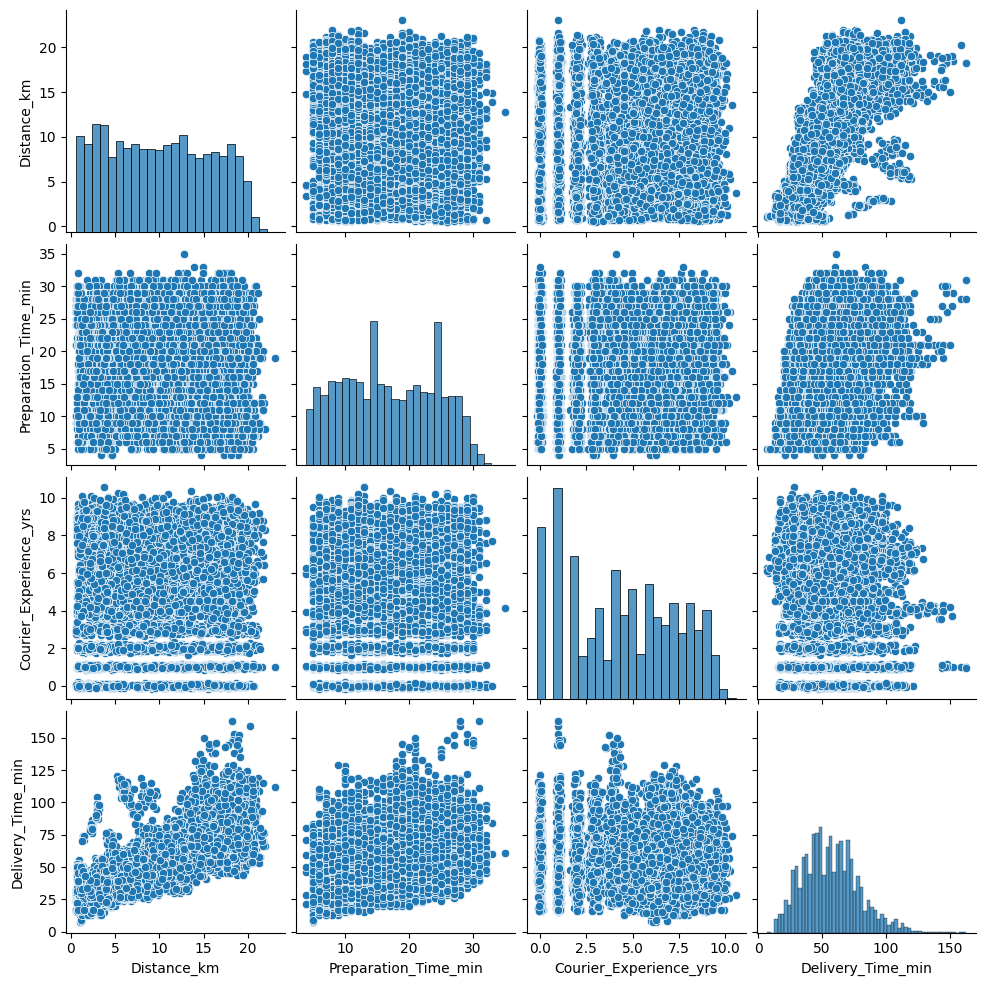

In [6]:
# Distribution plots for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
sns.pairplot(df[numerical_cols])


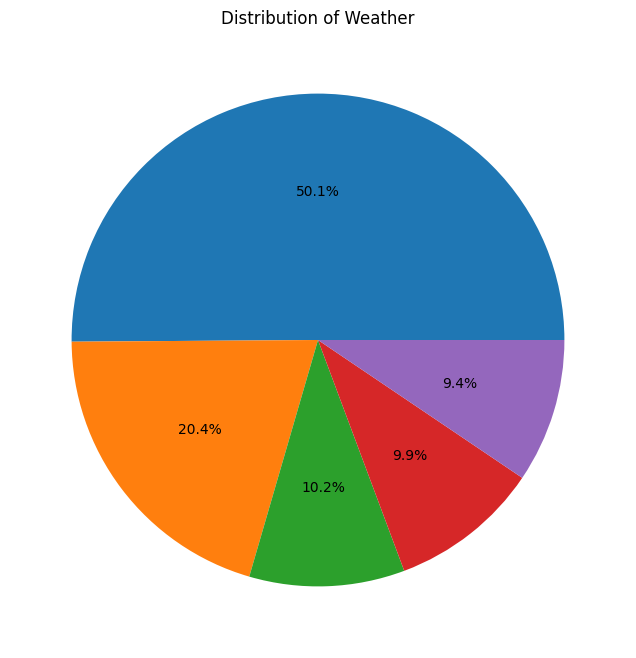

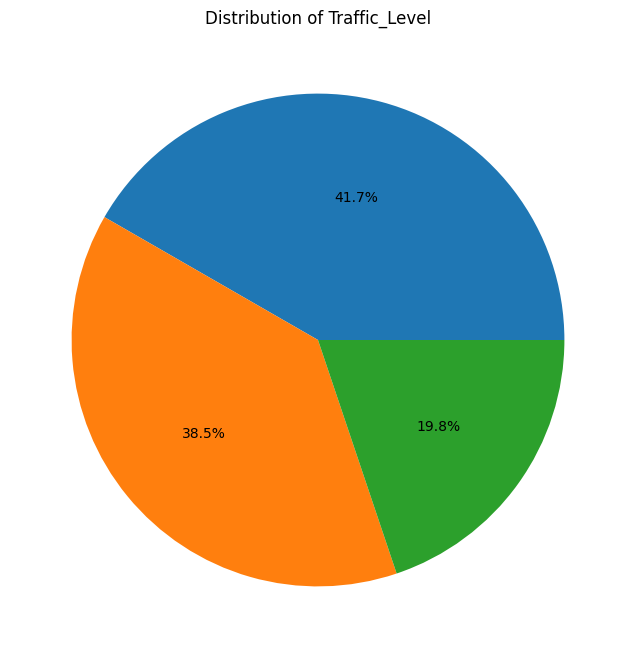

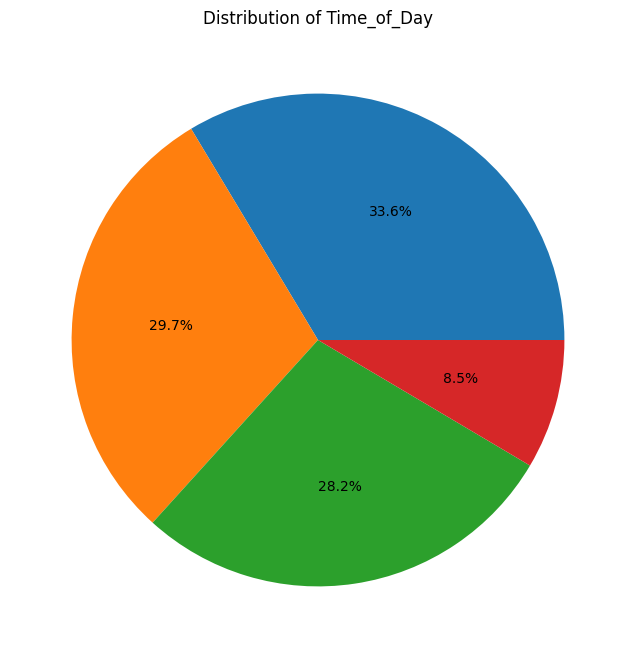

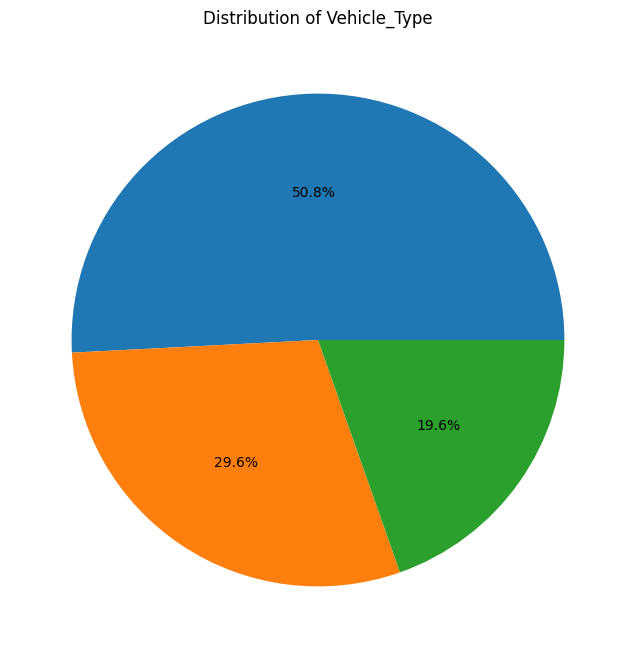

In [ ]:
# plotting for categorical features
categorical_cols = df.select_dtypes(include=['object']).columns

# using pie chart to show the distribution of categorical features
for col in categorical_cols:
    plt.figure(figsize=(10, 8))
    plt.pie(df[col].value_counts(), autopct='%1.1f%%')
    plt.title(f'Distribution of {col}')
    plt.show()



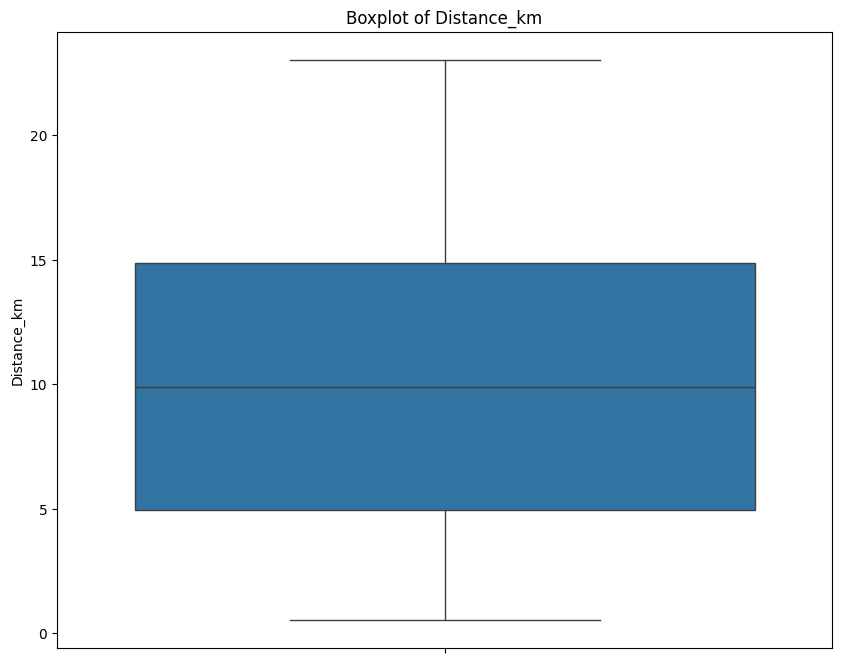

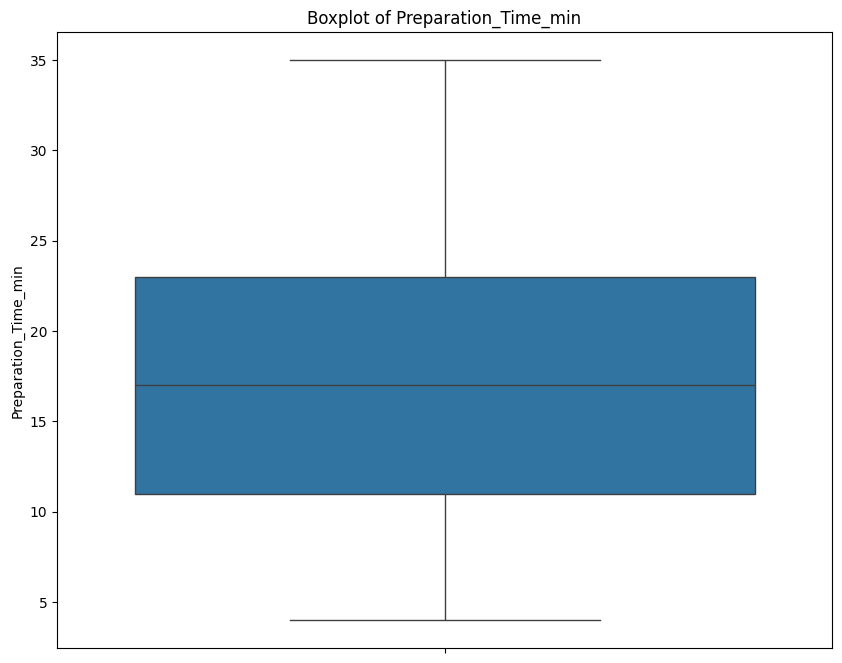

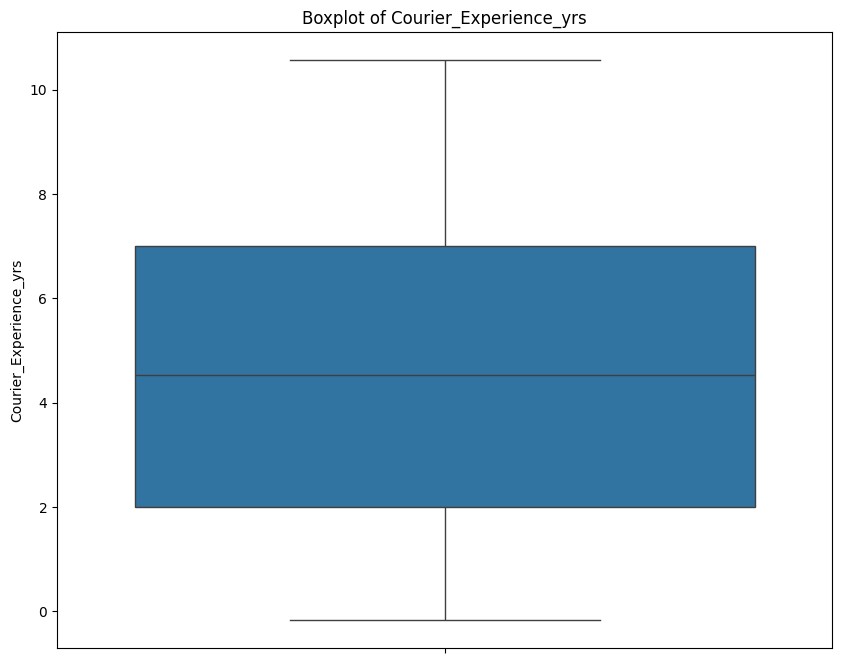

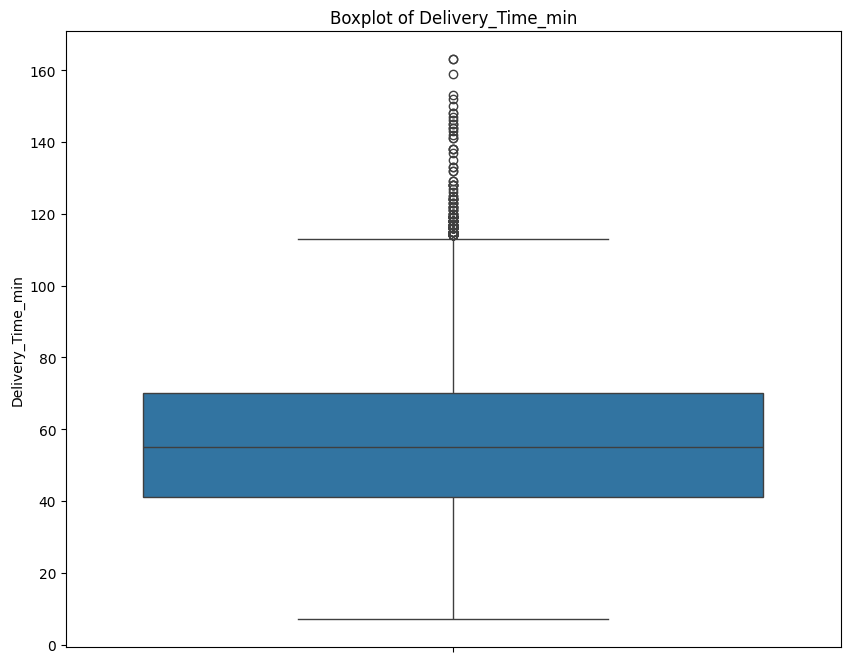

In [12]:
# for numerical features using boxplot
for col in numerical_cols:
    plt.figure(figsize=(10, 8))
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

## 3. Data Preprocessing Pipeline

In [15]:
# Define feature columns
NUMERIC_FEATURES = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
NUMERIC_FEATURES.remove('Delivery_Time_min')  # Removing target variable
CATEGORICAL_FEATURES = df.select_dtypes(include=['object']).columns.tolist()
TARGET = 'Delivery_Time_min'

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('power', PowerTransformer(standardize=True)),
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES),
        ('cat', categorical_transformer, CATEGORICAL_FEATURES)
    ])

# Split the data
X = df.drop(TARGET, axis=1)
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 4. Optuna Hyperparameter Optimization


In [16]:
def create_model(trial, model_name):
    if model_name == 'linear':
        alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
        return ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    
    elif model_name == 'decision_tree':
        return DecisionTreeRegressor(
            max_depth=trial.suggest_int('max_depth', 3, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
            random_state=42
        )
    
    elif model_name == 'random_forest':
        return RandomForestRegressor(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10),
            random_state=42
        )
    
    elif model_name == 'xgboost':
        return xgb.XGBRegressor(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            max_depth=trial.suggest_int('max_depth', 3, 20),
            learning_rate=trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            subsample=trial.suggest_float('subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),
            random_state=42
        )
    
    elif model_name == 'adaboost':
        return AdaBoostRegressor(
            n_estimators=trial.suggest_int('n_estimators', 50, 300),
            learning_rate=trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            random_state=42
        )

def objective(trial, model_name, X, y, preprocessor):
    model = create_model(trial, model_name)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    score = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    return -score.mean()

In [17]:
# Dictionary to store best models
best_models = {}
model_names = ['linear', 'decision_tree', 'random_forest', 'xgboost', 'adaboost']

for model_name in model_names:
    print(f"\nOptimizing {model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, model_name, X_train, y_train, preprocessor),
                  n_trials=50)
    
    # Create and store the best model
    best_model = create_model(study.best_trial, model_name)
    best_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', best_model)
    ])
    best_pipeline.fit(X_train, y_train)
    best_models[model_name] = best_pipeline
    
    print(f"Best {model_name} parameters:", study.best_params)
    print(f"Best MSE: {study.best_value}")

[I 2025-03-19 11:18:26,949] A new study created in memory with name: no-name-75b1bf22-1a9a-4e87-a6d6-290cd807ff0a



Optimizing linear...


[I 2025-03-19 11:18:27,238] Trial 0 finished with value: 123.54376909393841 and parameters: {'alpha': 0.016854206821658207, 'l1_ratio': 0.1451735159142955}. Best is trial 0 with value: 123.54376909393841.
[I 2025-03-19 11:18:27,440] Trial 1 finished with value: 131.0048211607405 and parameters: {'alpha': 0.083476022274954, 'l1_ratio': 0.11400508625360117}. Best is trial 0 with value: 123.54376909393841.
[I 2025-03-19 11:18:27,676] Trial 2 finished with value: 136.72963222442277 and parameters: {'alpha': 0.1257216566089138, 'l1_ratio': 0.04255929617540821}. Best is trial 0 with value: 123.54376909393841.
[I 2025-03-19 11:18:27,948] Trial 3 finished with value: 128.59513324442713 and parameters: {'alpha': 0.21933211469092082, 'l1_ratio': 0.9257214058676881}. Best is trial 0 with value: 123.54376909393841.
[I 2025-03-19 11:18:28,273] Trial 4 finished with value: 122.7858524796255 and parameters: {'alpha': 2.334526493659519e-05, 'l1_ratio': 0.7107453010593392}. Best is trial 4 with value: 

Best linear parameters: {'alpha': 0.002559706989228429, 'l1_ratio': 0.997599465042312}
Best MSE: 122.78439308982531

Optimizing decision_tree...


[I 2025-03-19 11:18:38,467] Trial 0 finished with value: 80.95257163213883 and parameters: {'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 0 with value: 80.95257163213883.
[I 2025-03-19 11:18:38,701] Trial 1 finished with value: 177.12834942192478 and parameters: {'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 0 with value: 80.95257163213883.
[I 2025-03-19 11:18:38,994] Trial 2 finished with value: 78.92753576333368 and parameters: {'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 7}. Best is trial 2 with value: 78.92753576333368.
[I 2025-03-19 11:18:39,299] Trial 3 finished with value: 69.16506854362719 and parameters: {'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 3 with value: 69.16506854362719.
[I 2025-03-19 11:18:39,609] Trial 4 finished with value: 68.57464272282061 and parameters: {'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 4 with value:

Best decision_tree parameters: {'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best MSE: 67.85911113665203

Optimizing random_forest...


[I 2025-03-19 11:19:04,509] Trial 0 finished with value: 151.0765160458024 and parameters: {'n_estimators': 279, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 151.0765160458024.
[I 2025-03-19 11:19:24,299] Trial 1 finished with value: 56.34833165675359 and parameters: {'n_estimators': 255, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 56.34833165675359.
[I 2025-03-19 11:19:34,158] Trial 2 finished with value: 151.07269210379297 and parameters: {'n_estimators': 284, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 1 with value: 56.34833165675359.
[I 2025-03-19 11:19:50,768] Trial 3 finished with value: 59.175987836077546 and parameters: {'n_estimators': 249, 'max_depth': 9, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 56.34833165675359.
[I 2025-03-19 11:19:55,533] Trial 4 finished with value: 92.22794067599384 and parameters: {'n_esti

Best random_forest parameters: {'n_estimators': 290, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best MSE: 35.2991979843912

Optimizing xgboost...


[I 2025-03-19 11:36:28,163] Trial 0 finished with value: 50.55443986214284 and parameters: {'n_estimators': 160, 'max_depth': 10, 'learning_rate': 0.19761933521841255, 'subsample': 0.8872500163890165, 'colsample_bytree': 0.5613491735263945}. Best is trial 0 with value: 50.55443986214284.
[I 2025-03-19 11:36:43,650] Trial 1 finished with value: 449.17881550595723 and parameters: {'n_estimators': 269, 'max_depth': 18, 'learning_rate': 0.000330461315453863, 'subsample': 0.9736692774748141, 'colsample_bytree': 0.5048974454555701}. Best is trial 0 with value: 50.55443986214284.
[I 2025-03-19 11:36:57,620] Trial 2 finished with value: 35.10047040071339 and parameters: {'n_estimators': 275, 'max_depth': 12, 'learning_rate': 0.025573982011385468, 'subsample': 0.6415667523908544, 'colsample_bytree': 0.7871757597674818}. Best is trial 2 with value: 35.10047040071339.
[I 2025-03-19 11:37:03,379] Trial 3 finished with value: 416.97179083380627 and parameters: {'n_estimators': 271, 'max_depth': 10,

Best xgboost parameters: {'n_estimators': 245, 'max_depth': 19, 'learning_rate': 0.02446047874988047, 'subsample': 0.5669301872754121, 'colsample_bytree': 0.9459694839443891}
Best MSE: 33.73090001011018

Optimizing adaboost...


[I 2025-03-19 11:50:53,705] Trial 0 finished with value: 173.22778187321597 and parameters: {'n_estimators': 257, 'learning_rate': 0.001560395908765163}. Best is trial 0 with value: 173.22778187321597.
[I 2025-03-19 11:50:56,592] Trial 1 finished with value: 292.60869112570805 and parameters: {'n_estimators': 211, 'learning_rate': 0.6910852593567381}. Best is trial 0 with value: 173.22778187321597.
[I 2025-03-19 11:51:00,303] Trial 2 finished with value: 168.82381378811664 and parameters: {'n_estimators': 71, 'learning_rate': 0.045344813274781744}. Best is trial 2 with value: 168.82381378811664.
[I 2025-03-19 11:51:11,019] Trial 3 finished with value: 169.17521784230888 and parameters: {'n_estimators': 215, 'learning_rate': 0.01574914467117301}. Best is trial 2 with value: 168.82381378811664.
[I 2025-03-19 11:51:15,382] Trial 4 finished with value: 173.58543288113253 and parameters: {'n_estimators': 88, 'learning_rate': 0.006309295631587772}. Best is trial 2 with value: 168.82381378811

Best adaboost parameters: {'n_estimators': 71, 'learning_rate': 0.045344813274781744}
Best MSE: 168.82381378811664


## 5. Model Evaluation on Test Data

Model Performance on Test Data:
                      MSE       RMSE        R2
linear         121.093848  11.004265  0.749866
decision_tree   62.748161   7.921374  0.870386
random_forest   29.426885   5.424655  0.939215
xgboost         26.918997   5.188352  0.944396
adaboost       178.579113  13.363350  0.631123


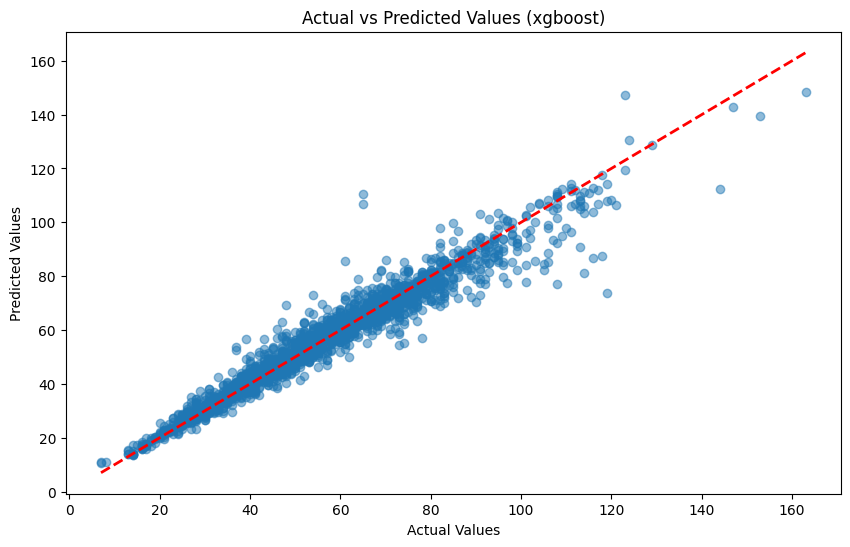

In [18]:
results = {}

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Display results
results_df = pd.DataFrame(results).T
print("Model Performance on Test Data:")
print(results_df)

# Plot actual vs predicted values for the best model
best_model_name = min(results.items(), key=lambda x: x[1]['MSE'])[0]
best_model = best_models[best_model_name]
y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values ({best_model_name})')
plt.show()


## 6. Save Best Model

In [19]:
# Save the best model
best_model = best_models[best_model_name]
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model ({best_model_name}) saved as 'best_model.pkl'")


Best model (xgboost) saved as 'best_model.pkl'
